# Импорты

In [17]:
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [48]:
%pip install --upgrade torchvision torchaudio torch

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 70.4 MB/s eta 0:00:00


In [1]:
#!g2.mig
import torch
torch.__version__

'2.0.1+cu117'

In [10]:
#!g2.mig
import pandas as pd
import numpy as np
import copy

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from PIL import Image
from tqdm.notebook import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import lr_scheduler
import torchvision.models as models
import torch.nn.init as init

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import warnings

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

warnings.filterwarnings('ignore')

from torchvision.models import VGG16_BN_Weights, vgg16_bn

weights = VGG16_BN_Weights.DEFAULT
model = vgg16_bn(weights=weights)
transform = weights.transforms()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /tmp/xdg_cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:06<00:00, 83.3MB/s] 


In [2]:
#!g2.mig
class goodsDataset(Dataset):
    LABELS = {
        "clean_photo": 0,
        "infographics": 1,
    }

    def __init__(self, df, label_column_name, path_column_name, transform=None):
        """
        Arguments:
            df : pandas DataFrame.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = df
        self.label_column_name = label_column_name
        self.path_column_name = path_column_name
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        try:
            path = self.data_frame[[self.path_column_name]].iloc[idx][0]
            image = Image.open(path).convert("RGB")

            if self.transform:
                image = self.transform(image)

        except Exception as e:
            print(f"произошла ошибка в goodsDataset при загрузки картинки: {e}")

        label = torch.tensor(
            goodsDataset.LABELS[
                self.data_frame[[self.label_column_name]].iloc[idx][0]
            ]
        )

        sample = [image, label]
        return sample


def load_data(df, transform, label_column_name, path_column_name, batch_size=4, num_workers=0, shuffle=True):
    goods_dataset = goodsDataset(df=df, label_column_name=label_column_name, transform=transform, path_column_name=path_column_name)
    dataloader = DataLoader(
        goods_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers
    )
    return dataloader


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()


def train_model(model,
                train_loader,
                test_loader,
                criterion,
                optimizer,
                NUM_EPOCHS,
                name_file_save,
                device='cpu',
                scheduler=None,
                save=True):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []
    best_accuracy = 0.0
    best_weights = copy.deepcopy(model.state_dict())

    for epoch in range(1, NUM_EPOCHS + 1):
        train_loss, train_accuracy = 0.0, 0.0
        model.train()
        for images, labels in tqdm(train_loader, desc='Training'):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            # images: batch_size x num_channels x height x width
            logits = model(images)
            # logits: batch_size x num_classes
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.shape[0]
            train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        if scheduler is not None:
            scheduler.step()

        train_loss /= len(train_loader.dataset)
        train_accuracy /= len(train_loader.dataset)
        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        
        if save:
            torch.save(model.state_dict(), name_file_save + '.pth')

        true_label = np.array([])
        predict_label = np.array([])
        test_loss, test_accuracy = 0.0, 0.0
        model.eval()
        for images, labels in tqdm(test_loader, desc='Validating'):
            true_label = np.append(true_label, labels.cpu().numpy())
            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                logits = model(images)
                # logits: batch_size x num_classes
                loss = criterion(logits, labels)
                probabilities = torch.softmax(logits, dim=1)  # Преобразование логитов в вероятности
                predicted_class = torch.argmax(probabilities, dim=1)
                predict_label = np.append(predict_label, predicted_class.cpu().numpy())

            test_loss += loss.item() * images.shape[0]
            test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        test_loss /= len(test_loader.dataset)
        test_accuracy /= len(test_loader.dataset)
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_weights = copy.deepcopy(model.state_dict())

        model.load_state_dict(best_weights)
        if save:
            torch.save(model.state_dict(), name_file_save + '.pth')

        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)
        print(classification_report(true_label, predict_label))
    
    return train_losses, train_accuracies, test_losses, test_accuracies

In [3]:
#!g2.mig

df = pd.read_csv("data_for_binary.csv") # .sample(1000, random_state=13)
label_column_name = "verdict"
path_column_name = "path"

train, test = train_test_split(
    df[[path_column_name, label_column_name]], 
    random_state=42, 
    test_size=0.2)

train_loader = load_data(
    train, transform, 
    label_column_name, 
    path_column_name, 
    batch_size=20)

test_loader = load_data(
    test, 
    transform, 
    label_column_name, 
    path_column_name, 
    batch_size=20, 
    shuffle=False)

In [4]:
#!g2.mig
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Замораживаем все слои
for param in model.parameters():
    param.requires_grad = False
    
# Размораживаем параметры последнего полносвязанного слоя (classifier)
for param in model.classifier.parameters():
    param.requires_grad = True


# model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
num_classes = 2
num_neuron = 512
# model.head = nn.Linear(model.head.in_features, num_classes)
model.classifier = nn.Sequential(
    nn.Linear(25088, 100),
    nn.Softmax(),
    nn.Linear(100, 2)
#     nn.BatchNorm1d(512),
#     nn.ELU(),
#     nn.Dropout(0.5),
    
#     nn.Linear(512, 256),
#     nn.BatchNorm1d(256),
#     nn.ReLU(),
#     nn.Dropout(0.1),
    
#     nn.Linear(256, 64),
#     nn.BatchNorm1d(64),
#     nn.ReLU(),
#     nn.Dropout(0.1),
    
#     nn.Linear(64, 8),
#     nn.LeakyReLU(),
    
#     nn.Linear(8, 2)
    

)

#     nn.Linear(num_neuron, num_neuron // 2),
#     nn.BatchNorm1d(num_neuron // 2),
#     nn.ReLU(),
#     nn.Dropout(0.5),
    
#     nn.Linear(num_neuron // 2, num_neuron // 4),
#     nn.BatchNorm1d(num_neuron // 4),
#     nn.ReLU(),
#     nn.Dropout(0.1),
    
#     nn.Linear(num_neuron // 4, num_neuron // 8),
#     nn.BatchNorm1d(num_neuron // 8),
#     nn.ReLU(),
#     nn.Dropout(0.1),
    
#     nn.Linear(num_neuron // 8, num_neuron // 16),
#     nn.BatchNorm1d(num_neuron // 16),
#     nn.Linear(num_neuron // 16, num_classes)
# )

import torch.nn.init as init

def initialize_weights(layer):
    if isinstance(layer, nn.Linear):
        init.xavier_uniform_(layer.weight)
        if layer.bias is not None:
            init.constant_(layer.bias, 0)

# Применяем инициализацию ко всем слоям внутри nn.Sequential
model.classifier.apply(initialize_weights)

model = model.to(device)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [5]:
#!g2.mig
torch.cuda.empty_cache()

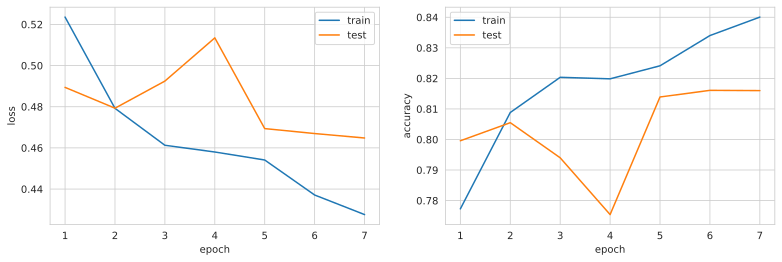

              precision    recall  f1-score   support

         0.0       0.87      0.75      0.81      6091
         1.0       0.77      0.88      0.83      5909

    accuracy                           0.82     12000
   macro avg       0.82      0.82      0.82     12000
weighted avg       0.82      0.82      0.82     12000



In [6]:
#!g2.mig

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

criterion = nn.CrossEntropyLoss().to(device)
NUM_EPOCHS = 7 # 40 = 40

# optimizer = torch.optim.NAdam(model.parameters(), lr=0.002, weight_decay=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.002, verbose=True, weight_decay=0.2)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=0.001, weight_decay=0.01, fused=True)

# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.02, verbose=True)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=0, verbose=True)
name_file_save = "model_gr_or_ph"


train_losses, train_accuracies, test_losses, test_accuracies = train_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    NUM_EPOCHS,
    name_file_save,
    device=device,
    scheduler=scheduler,
    save=True
)

In [ ]:
#!g2.mig


In [ ]:
#!g2.mig


In [ ]:
#!g2.mig


In [ ]:
#!g2.mig


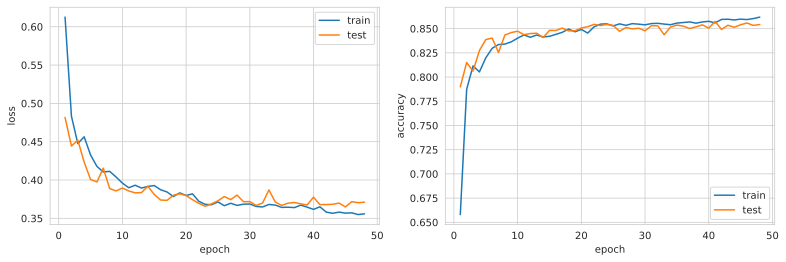

              precision    recall  f1-score   support

         0.0       0.86      0.85      0.86      6091
         1.0       0.85      0.86      0.85      5909

    accuracy                           0.85     12000
   macro avg       0.85      0.85      0.85     12000
weighted avg       0.85      0.85      0.85     12000



KeyboardInterrupt: 

In [13]:
#!g2.mig
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Замораживаем все слои
for param in model.parameters():
    param.requires_grad = True # torch.rand(1).item() < 0.3

# Размораживаем параметры последнего полносвязанного слоя (classifier)
for param in model.classifier.parameters():
    param.requires_grad = True

num_classes = 2
num_neuron = 512
# model.head = nn.Linear(model.head.in_features, num_classes)
model.classifier = nn.Sequential(
    nn.Linear(25088, 100),
    nn.Softmax(),
    nn.Linear(100, 2)
)

model.load_state_dict(torch.load('model_gr_or_ph.pth', map_location=torch.device(device)))
model = model.to(device)

criterion = nn.CrossEntropyLoss().to(device)
NUM_EPOCHS = 100 # 40 = 40

# optimizer = torch.optim.NAdam(model.parameters(), lr=0.002, weight_decay=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.002, verbose=True, weight_decay=0.2)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01, fused=True)

# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.02, verbose=True)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-4, verbose=True)
name_file_save = "model_gr_or_ph"


train_losses, train_accuracies, test_losses, test_accuracies = train_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    NUM_EPOCHS,
    name_file_save,
    device=device,
    scheduler=scheduler,
    save=True
)

In [ ]:
#!g2.mig
# для 20 эпох
plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

In [ ]:
#!g2.mig
import os

def find_pth_files(directory):
    pth_files = []
    try:
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.endswith('.pth'):
                    pth_files.append(os.path.join(root, file))
        return pth_files
    except Exception as e:
        print(e)

starting_directory = '/'  # Ваша начальная директория
pth_files = find_pth_files(starting_directory)

for pth_file in pth_files:
    print("Found .pth file:", pth_file)


In [ ]:
#!g2.mig
